# Extract Polygonal Boundary Points

That's the goal...

In [146]:
import xml.etree.ElementTree as ET

def read_points(gdml_file, x_axis = 'x', y_axis = 'y', z_axis = 'z', z_cut = 0.5, reflect = None) :
    tree = ET.parse(gdml_file)
    positions = []
    for definition in tree.getroot()[0] :
        if definition.tag == 'position' and float(definition.attrib[z_axis]) < z_cut :
            pt = [float(definition.attrib[x_axis]), float(definition.attrib[y_axis])]
            if reflect is not None :
                if reflect == 'x' :
                    pt = [pt[0],-pt[1]]
                elif reflect == 'y' :
                    pt = [-pt[0],pt[1]]
                else :
                    raise KeyError(f'Reflection over {reflect} not provided.')
            positions.append(pt)
    return positions

import matplotlib.pyplot as plt

def scatter(pts) :
    plt.scatter(*zip(*pts))

def show_points(pts) :
    scatter(pts)
    plt.gca().set_aspect('equal')
    plt.show()
    
def connect_points(pts) :
    plt.plot(*zip(*pts))
    plt.gca().set_aspect('equal')
    plt.show()
    
def center(pts, center = 'avg') :
    if len(pts) == 0 :
        return pts
    
    center_pt = [0.,0.]
    if isinstance(center,str) :
        if center == 'avg' :
            for x,y in pts :
                center_pt[0] += x
                center_pt[1] += y
            center_pt[0] /= len(points)
            center_pt[1] /= len(points)
        elif center == 'half_max' :
            center_pt = [max(x)/2 for x in zip(*pts)]
        else :
            raise KeyError(f'Center calculation {center} not recognized.')
    else :
        center_pt = center
            
    return [(x - center_pt[0], y - center_pt[1]) for x,y in pts]

import math

def unique(pts, too_close = 1.) :
    unique_pts_grps = []
    
    def dist(p1, p2) :
        return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
    
    for pt in pts :
        found_grp = False
        for upg in unique_pts_grps :
            if dist(upg[0],pt) < 40 :
                upg.append(pt)
                found_grp = True
                break
        if not found_grp :
            unique_pts_grps.append([pt])

    # the unique points are the average points within each unique point group
    return [[sum(x)/len(x) for x in zip(*upg)] for upg in unique_pts_grps]

def byangle(pt) :
    """sort by going around the circle
    
    assuming points are already centered on the origin
    
    https://stackoverflow.com/a/41856340
    """
    (x,y) = pt
    r = math.hypot(x,y)
    if r == 0 :
        return -math.pi, 0
    angle = math.atan2(x/r,y/r)
    if angle < 0 :
        return 2*math.pi+angle, r
    return angle, r

def print_to_gdml_matrix(**kwargs) :
    for name, pts in kwargs.items() :
        newline_list = f'{pts[0][0]:.2f} {pts[0][1]:.2f}\n' + '\n'.join([f'                {x:.2f} {y:.2f}' for x,y in pts[1:]])
        print(f'<matrix name="{name}"')
        print( '        coldim="2"')
        print(f'        values="{newline_list}"/>')

## Tungsten

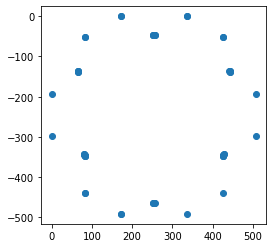

In [147]:
points = read_points('tungsten_plate.gdml', x_axis = 'z', y_axis = 'x', z_axis = 'y', reflect = 'x')
show_points(points)

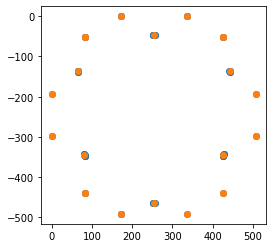

18

In [151]:
scatter(points)
uniq_pts = unique(points, too_close=50.)
show_points(uniq_pts)
len(uniq_pts)

In [164]:
uniq_pts

[[171.45, 0.0],
 [82.55, -51.32644],
 [508.0, -194.3072],
 [508.0, -296.9601],
 [253.99999999999997, -46.29787428571428],
 [81.37013714285715, -345.30159999999995],
 [426.62987142857145, -345.30160000000006],
 [254.00003999999998, -463.3822],
 [442.57579999999996, -136.7594],
 [425.45, -51.32644],
 [336.55, 0.0],
 [65.424242, -136.7594],
 [82.55, -439.9409],
 [171.45, -491.2674],
 [425.45, -439.9409],
 [336.55, -491.2674],
 [0.0, -296.9601],
 [0.0, -194.3072]]

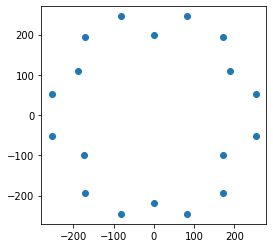

In [165]:
center_pts = center(uniq_pts, center = [508/2,-491.2674/2])
show_points(center_pts)

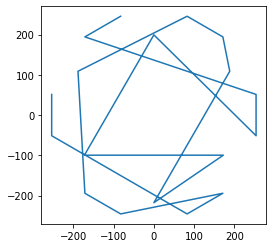

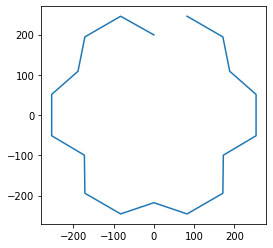

In [166]:
connect_points(center_pts)
sort_pts = list(sorted(center_pts, key = byangle))
connect_points(sort_pts)

In [167]:
print_to_gdml_matrix(absorber_polygon = sort_pts)

<matrix name="absorber_polygon"
        coldim="2"
        values="82.55 245.63
                171.45 194.31
                188.58 108.87
                254.00 51.33
                254.00 -51.33
                172.63 -99.67
                171.45 -194.31
                82.55 -245.63
                0.00 -217.75
                -82.55 -245.63
                -171.45 -194.31
                -172.63 -99.67
                -254.00 -51.33
                -254.00 51.33
                -188.58 108.87
                -171.45 194.31
                -82.55 245.63
                -0.00 199.34"/>


## Motherboard

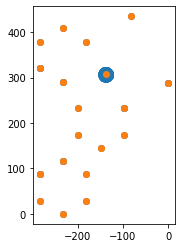

In [171]:
points = read_points('motherboard5_only.gdml',x_axis='x',y_axis='z',z_axis='y',reflect='y')
scatter(points)
uniq_pts = unique(points)
show_points(uniq_pts)

In [172]:
uniq_pts

[[-182.0325, 378.8771],
 [-82.65631, 435.0652],
 [-232.8325, 408.2065],
 [-283.6325, 378.8771],
 [-283.6325, 320.2183],
 [-232.8325, 290.8889],
 [-199.6601, 233.4326],
 [-199.6601, 174.7739],
 [-232.8325, 117.3176],
 [-283.6325, 87.98818],
 [-283.6325, 29.32939],
 [-232.8325, 0.0],
 [-182.0325, 29.32939],
 [-182.0325, 87.98818],
 [-148.8601, 145.4445],
 [-98.06006, 174.7739],
 [-98.06006, 233.4326],
 [0.0, 288.8767],
 [-138.07887222222223, 307.2907333333334]]

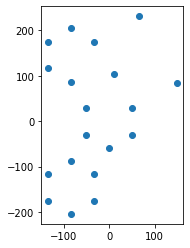

In [177]:
# center MB on center of center hexagon
center_pts = center(uniq_pts, center = [-148.8601, 408.2065/2])
show_points(center_pts)

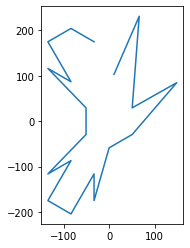

In [179]:
connect_points(sorted(center_pts, key = byangle))

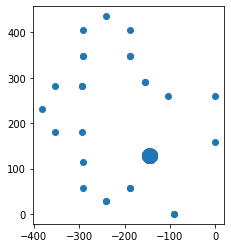

In [119]:
show_points(read_points('motherboard6_only.gdml',x_axis='x',y_axis='z',z_axis='y',reflect='y'))